<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

> Блок с отступами



## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
import os
from tqdm import tqdm_notebook
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import skimage.io
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle, islice
from copy import deepcopy
%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = r"lfw_attributes.txt",
                      images_name = r"lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):
    cwd = os.getcwd()
    
    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv(attrs_name,sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

In [5]:
def show_img(lenth=5):
    ids = np.random.choice(len(train_photos), lenth)
    _, axs = plt.subplots(lenth, 1, figsize=(12, 12))
    for item, ax in zip(ids,axs.flat):
        ax.imshow(train_photos[item])
    plt.show()

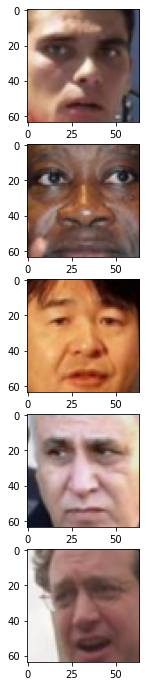

In [6]:
show_img()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [7]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=3*64*64, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=hidden)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=hidden, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=3*64*64)
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    def forward(self, x):
        x = self.flatten(x).float()
        latent = self.encoder(x)#.view(-1, 2, hidden)
        # get `mu` and `log_var`
#         mu = latent[:, 0, :] # the first feature values as mean
#         log_var = latent[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
#         z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(latent)
#         <реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
#         и полученная реконструкция изображения (reconstruction)>
        
        return reconstructed, latent
    
    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        return z

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [10]:
hidden=64

criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [11]:
print(autoencoder)

Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=12288, bias=True)
  )
)


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [12]:
# <тут Ваш код тренировки автоэнкодера>
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, _ = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(batch.to(device).float(), reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            reconstruction, _ = autoencoder(batch.to(device))
            reconstruction = reconstruction.view(-1, 64, 64, 3)
            loss = criterion(batch.to(device).float(), reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-12-b0d001bb646d>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

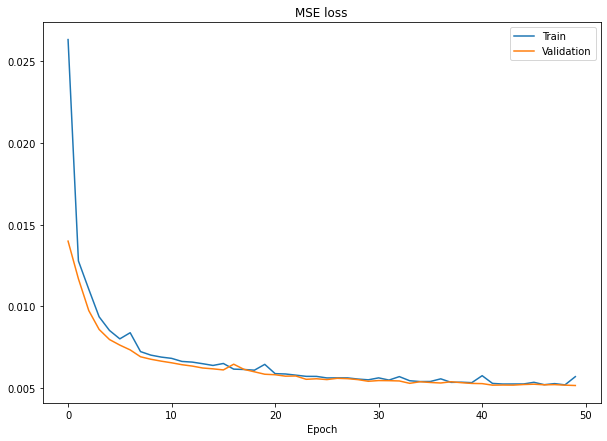

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

# plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [60]:
latent_space = np.empty([1, 64])

autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
        reconstruction, latent = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        latent_space=np.append(latent_space,latent.cpu().detach().numpy(), axis=0)
#         break
latent_space.shape

(1316, 64)

In [63]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [136]:
def find_best_fit_distribution(data, ax=None):
    # print('data', data)
    y, _ = np.histogram(data, bins=200, density=True)
    x = np.arange(201)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    # print('rolled', x)

    ### Distributions to check in scipy
    #continiuos
    DISTRIBUTIONS = [d for d in dir(scipy.stats) if
                     isinstance(getattr(scipy.stats, d), scipy.stats.rv_continuous)][:59]
    #descrete
    DISTRIBUTIONS_D = [d for d in dir(scipy.stats) if
                       isinstance(getattr(scipy.stats, d), scipy.stats.rv_discrete)]

    # Best distribution starts from norm =).
    best_distribution = scipy.stats.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for dist in tqdm_notebook(DISTRIBUTIONS, desc='Find_best_fit_distribution', leave=True):
        distribution = getattr(scipy.stats, dist)
        print(f'Checking - {dist}')
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                ### fit dist to data
                params = distribution.fit(data)
                # print(dist)
                print('params - ', params)

                ### Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                ### Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                # print('pdf -', pdf)
                print('sse -', sse)
                print('best sse -', best_sse)

                ### identify if current distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
        except Exception as exc:
            print(exc)
            pass
    print(best_distribution.name, best_params)
    return (best_distribution.name, best_params)


def make_pdf(dist, params):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    #Get same start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, num=64)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    
    ###pandas version
    pdf = pd.Series(y, x)
    return pdf


def display(data):
    best_fit_name, best_fit_params = find_best_fit_distribution(data)
    best_dist = getattr(scipy.stats, best_fit_name)
    pdf = make_pdf(best_dist, best_fit_params)
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data_ = pd.Series(data)
    data_.plot(kind='hist', bins=64, density=True, alpha=0.5, label='Data', legend=True, ax=ax)
    return 

<ipython-input-136-f1c72c7998e1>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for dist in tqdm_notebook(DISTRIBUTIONS, desc='Find_best_fit_distribution', leave=True):


Find_best_fit_distribution:   0%|          | 0/59 [00:00<?, ?it/s]

Checking - alpha
params -  (29.79929776713091, -16.882564967181835, 503.3285763349063)
sse - 24.921904084816518
best sse - inf
Checking - anglit
params -  (0.32492953904285937, 4.272475353623016)
sse - 24.813936291003728
best sse - 24.921904084816518
Checking - arcsine
params -  (-3.0308013781117853, 6.711252055983491)
sse - 24.82506868703141
best sse - 24.813936291003728
Checking - argus
params -  (4.1712748496751365e-05, -3.0311213432401107, 6.712149241321537)
sse - 24.85045091148063
best sse - 24.813936291003728
Checking - beta
params -  (638.3926045733053, 6584721.409387606, -14.299799059308711, 147900.03034505434)
sse - 24.947031824531987
best sse - 24.813936291003728
Checking - betaprime
params -  (2862.4809451007623, 2248.8013561116277, -20.06176498988762, 15.783453555220348)
sse - 24.94592253599044
best sse - 24.813936291003728
Checking - bradford
params -  (1.1502616289345964, -3.0305397626830186, 6.710990441175381)
sse - 24.764050982703292
best sse - 24.813936291003728
Checki

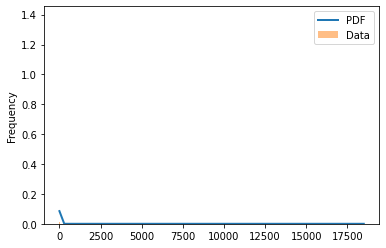

In [137]:
display(np.ravel(latent_space))

In [15]:
def view_result(num_images=10):
    plt.figure(figsize=(8, 8))
    for i, (gt, res) in enumerate(zip(ground_truth[:num_images], result[:num_images])):
        plt.subplot(num_images, 2, 2*i+1)
        plt.axis('off')
        plt.imshow(gt)
        plt.subplot(num_images, 2, 2*i+2)
        plt.axis('off')
        plt.imshow(res)

In [16]:
# https://github.com/lharries/PyTorch-Autoencoders/blob/master/autoencoders.ipynb
# https://colab.research.google.com/drive/15QeP23qdj1zQ51x_D6LZTW0DEKnPOqr4#scrollTo=6AfYIgiLWNd7

In [17]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(5,5)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow((list_of_images[i]))
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [18]:
def roundrobin(*iterables):
    pending = len(iterables)
    nexts = cycle(iter(it).__next__ for it in iterables)
    while pending:
        try:
            for next in nexts:
                yield next()
        except StopIteration:
            pending -= 1
            nexts = cycle(islice(nexts, pending))

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


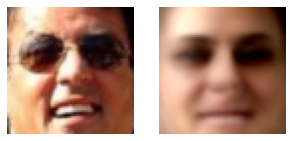

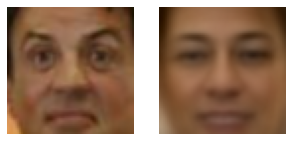

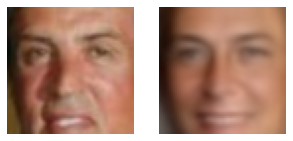

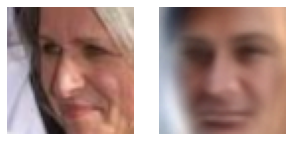

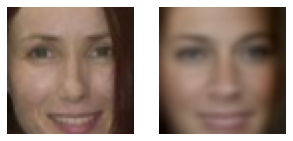

In [19]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
x = 5
grid_display(list(roundrobin(ground_truth[:x], result[:x])))

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

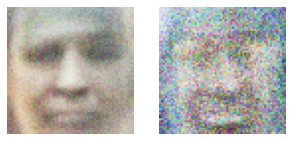

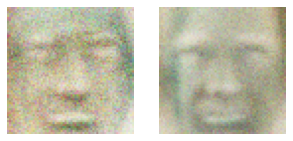

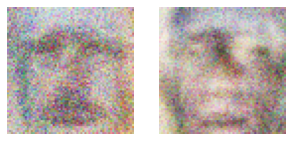

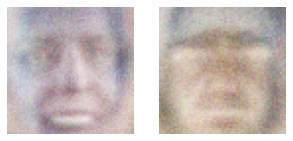

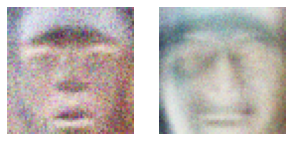

In [161]:
# сгенерируем 25 рандомных векторов размера latent_space
# TODO подобрать распределение до 0 1
# https://github.com/pranjaldatta/Denoising-Autoencoder-in-Pytorch/blob/master/DenoisingAutoencoder.ipynb
# https://medium.com/theleanprogrammer/denoising-images-using-autoencoders-4a64499f10ba
# z = np.random.randn(10, hidden)
z = np.array([np.random.normal(0.4, 2, 64) for i in range(10)])

distribution = getattr(scipy.stats, 'levy')
# z = [distribution.rvs(-3.038178589370678, 2.907428890711448, 64) for i in range(10)]
with torch.no_grad():
    inputs = torch.FloatTensor(z).to(device)
    autoencoder.eval()
    generated = autoencoder.decoder(inputs)
    generated = torch.sigmoid(generated)
    generated = generated.view(-1, 64, 64, 3)

grid_display([generated[i].cpu().detach().numpy() for i in range(generated.shape[0])])

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [22]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 64*64*3))
        inputs = inputs.to(device)
        autoencoder.eval()
        output = autoencoder.encoder(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(device)
        autoencoder.eval()
        output = autoencoder.decoder(inputs)        
        return output

In [57]:
def make_some1(ids, attr_vec):
    for id in ids:
        pic = data[id]
        latent_vec = to_latent(pic)
        latent_vec[0] += attr_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,64,64,3).cpu()
        grid_display(list(roundrobin(pic,pic_output)))

In [58]:
def get_attr_vec():
    attr = np.random.choice(attrs.columns.values, 1)[0]
    top=attrs.sort_values(by=attr, ascending=False)[:15].index.values
    bottom=attrs.sort_values(by=attr, ascending=False)[-15:].index.values
    attr_latent = to_latent(data[top]).mean(axis=0)
    no_attr_latent = to_latent(data[bottom]).mean(axis=0)
    print(attr)
    return attr_latent-no_attr_latent

### make some fun

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No Eyewear


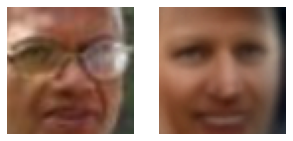

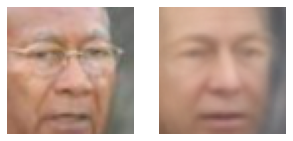

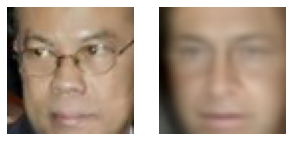

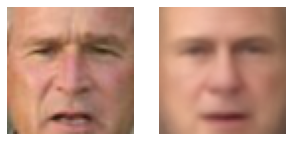

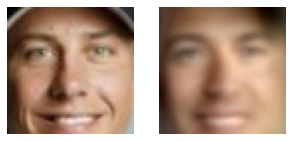

In [67]:
# random attr to random faces=)
make_some1([np.random.randint(len(data), size=5)], get_attr_vec())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [2]:
# https://www.kaggle.com/averkij/variational-autoencoder-and-faces-generation

In [13]:
from torchvision import transforms, utils
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #encoder
        self.fc1 = nn.Linear(28*28*1, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        
        #decoder
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 28*28*1)   
        
        #activation
        self.relu = nn.ReLU()
        
#         <определите архитектуры encoder и decoder
#         помните, у encoder должны быть два "хвоста", 
#         т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encoder(self, x):
        x = self.relu(self.fc1(x))
        mu, logsigma = self.fc21(x), self.fc22(x)
#         <реализуйте forward проход энкодера
#         в качестве ваозвращаемых переменных -- mu и logsigma>
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu

    def decoder(self, z):
        z = self.relu(self.fc3(z)) #1500
        reconstruction = torch.sigmoid(self.fc4(z))
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encoder(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [9]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [11]:
dim_z=100

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [12]:
# <тут Ваш код тренировки автоэнкодера>
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch,_ in train_loader:
        optimizer.zero_grad()
        batch=batch.view(-1,28*28*1)
        mu, logsigma, reconstruction = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch,_ in test_loader:
            batch=batch.view(-1,28*28*1)
            mu, logsigma, reconstruction = autoencoder(batch.to(device))
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-12-a7840f7522db>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

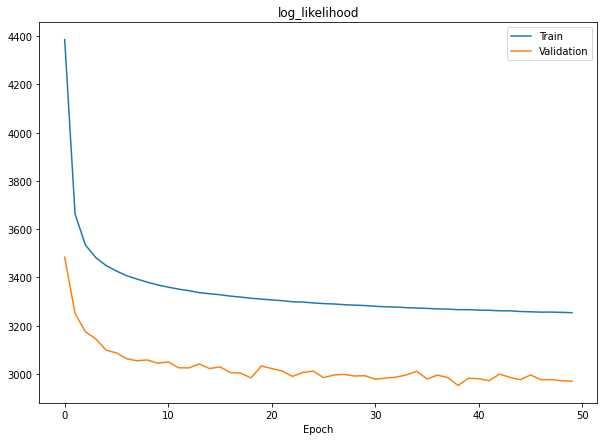

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

# plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('VAE')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [20]:
autoencoder.eval()
val_losses_per_epoch = []
with torch.no_grad():
    for batch,_ in test_loader:
        batch_ = batch.view(-1,28*28*1)
        _, _, reconstruction = autoencoder(batch_.to(device))
        reconstruction=reconstruction.view(32,28,28, 1)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.permute(0,2,3,1).numpy()
        break

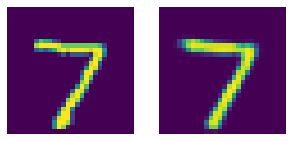

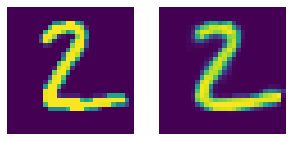

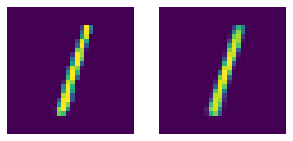

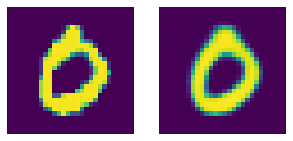

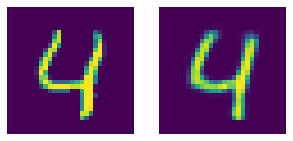

In [21]:
x = 5
grid_display(list(roundrobin(ground_truth[:x], result[:x])))

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

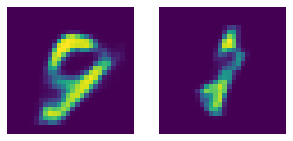

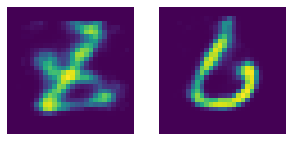

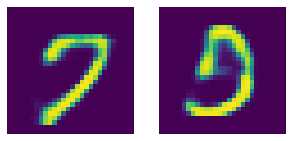

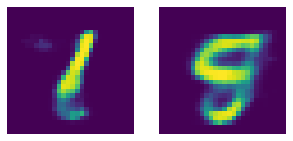

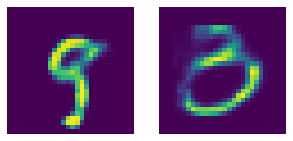

In [26]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
lenth=10
z = np.array([np.random.normal(0, 1, dim_z) for i in range(lenth)])

with torch.no_grad():
    inputs = torch.FloatTensor(z).to(device)
    autoencoder.eval()
    generated = autoencoder.decoder(inputs)
    generated = generated.view(lenth, 28, 28, 1)
    
grid_display([generated[i].cpu().detach().numpy() for i in range(generated.shape[0])])

In [ ]:
# https://github.com/OlgaChaganova/DeepLearningSchool-HomeWorks/blob/main/%D0%94%D0%97%207.%20%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B.ipynb

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [86]:
from sklearn.manifold import TSNE
import colorsys

In [28]:
def _get_n_hex_color(n=5):
    HSV_tuples = [(x * 1.0 / n, 0.5, 0.5) for x in range(n)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

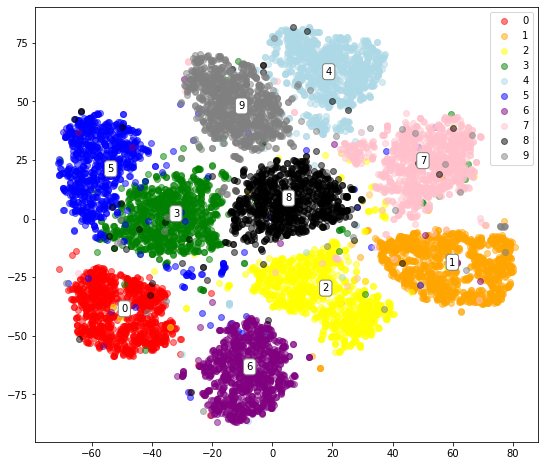

In [59]:
test_latent_vectors = []
test_labels = []

for imgs, labels in test_loader:
    imgs = imgs.view(-1,28*28*1).to(device)
    labels = labels.to(device)
    mu, logsigma = autoencoder.encoder(imgs)
    latent_vectors = autoencoder.gaussian_sampler(mu, logsigma)
    latent_vectors = latent_vectors.cpu().detach().numpy()
    test_latent_vectors.append(latent_vectors)
    test_labels.append(labels.cpu().detach().numpy())

X = test_latent_vectors[0]
y = test_labels[0]

for i in range(1, len(test_latent_vectors)):
    X = np.concatenate((X, test_latent_vectors[i]))
    y = np.concatenate((y, test_labels[i]))

X_embedded = TSNE(n_components=2).fit_transform(X)

fig, ax = plt.subplots(figsize=(9, 8))

colors = ['red', 'orange', 'yellow', 'green', 'lightblue', 'blue', 'purple', 'pink', 'black', 'gray']
# colors = _get_n_hex_color(n=10)
for num in list(np.arange(0,10)):
    x_ax = X_embedded[y == num][:,0]
    y_ax = X_embedded[y == num][:,1]
    ax.scatter(x_ax, y_ax, c=colors[num], label=str(num), alpha=0.5)
    ax.annotate(f"{num}", xy=(x_ax.mean(), y_ax.mean()),
            bbox=dict(boxstyle="round", fc="white", ec="gray"))
ax.legend()
plt.show()

Что вы думаете о виде латентного представления?

Неплохое отображение)

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [48]:
class CVAE(nn.Module):
    def __init__(self, dim_of_latent_vector):
        super(CVAE, self).__init__()
        self.dim_of_latent_vector = dim_of_latent_vector

        self.encoder = nn.Sequential(
            nn.Linear(28*28*1 + 10, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, self.dim_of_latent_vector*2)
        ) 

        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.dim_of_latent_vector + 10, out_features=128),
            nn.ReLU(),

            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=28*28*1),
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        ohe_labels = nn.functional.one_hot(labels, num_classes=10)
        x = torch.cat([x.view(-1, 28*28), ohe_labels], dim=1)
        mu, log_sigma = torch.split(self.encoder(x), self.dim_of_latent_vector, dim=1)
        return mu, log_sigma
    
    def gaussian_sampler(self, mu, log_sigma):
        if self.training:
            std = torch.exp(log_sigma)
            eps = torch.randn_like(std)
            sample = std * eps + mu
            return sample
        else:
            return mu
  
    def decode(self, z, labels):
        ohe_labels = nn.functional.one_hot(labels, num_classes=10)
        z = torch.cat([z, ohe_labels], dim=1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, labels):
        shapes = x.shape

        ohe_labels = nn.functional.one_hot(labels, num_classes=10)
        mu, log_sigma = self.encode(x, labels)

        sample = self.gaussian_sampler(mu, log_sigma)
        reconstruction = self.decode(sample, labels)
        return mu, log_sigma, reconstruction.view(*shapes)

In [51]:
def KL_divergence(mu, logsigma):
    loss = -0.5*torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum') 
    return loss(reconstruction, x)

def loss_vae(x, reconstruction, mu, logsigma):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [52]:
dim_z=100

criterion = loss_vae

autoencoder = CVAE(dim_z).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [54]:
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []

    for X_batch, label_batch in train_loader:
        X_batch = X_batch.to(device)
        label_batch = label_batch.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstructed = autoencoder(X_batch, label_batch)
        loss = criterion(X_batch, reconstructed, mu, logsigma)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, label_batch in test_loader:
            X_batch = X_batch.to(device)
            label_batch = label_batch.to(device)
            mu, logsigma, reconstructed = autoencoder(X_batch, label_batch)
            loss = criterion(X_batch, reconstructed, mu, logsigma)
            val_losses_per_epoch.append(loss.item())
    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-54-68abd02b7e62>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

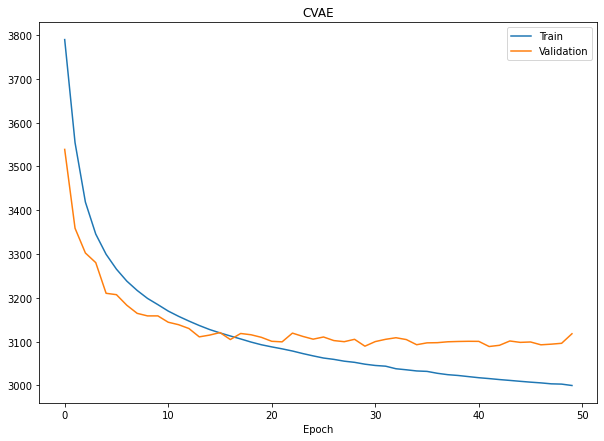

In [56]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

# plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('CVAE')
plt.legend()
plt.show()

In [57]:
autoencoder.eval()
val_losses_per_epoch = []
with torch.no_grad():
    for batch,label_batch in test_loader:
        batch_ = batch.view(-1,28*28*1)
        mu, logsigma, reconstruction = autoencoder(batch_.to(device), label_batch.to(device))
        reconstruction=reconstruction.view(32,28,28, 1)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.permute(0,2,3,1).numpy()
        break

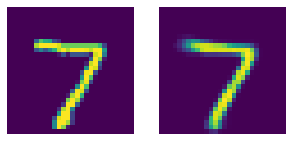

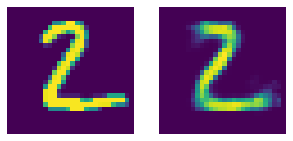

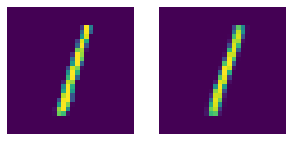

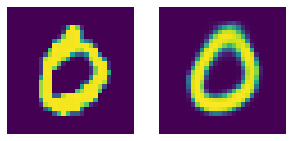

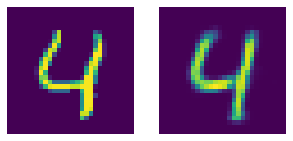

In [58]:
x = 5
grid_display(list(roundrobin(ground_truth[:x], result[:x])))

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [82]:
def generate_new_imgs_cvae(model, labels):
    latent_vectors = torch.rand([len(labels), dim_z])
    latent_vectors = latent_vectors.cpu().detach()

    output = model.decode(latent_vectors.to(device), labels)
    output = output.cpu().detach()
    output = output.view(len(labels), 1, 28, 28)
    return output

In [92]:
labels = [5,7,5,7,5,7,5,7,5,7]*4
labels = torch.tensor(labels[:batch_size]).to(device)
new_imgs = generate_new_imgs_cvae(autoencoder, labels)

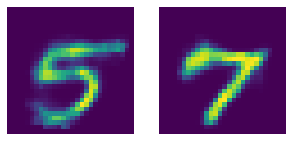

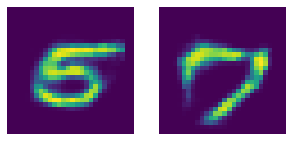

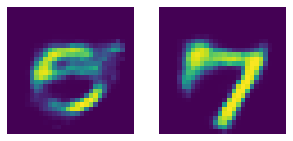

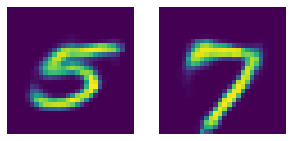

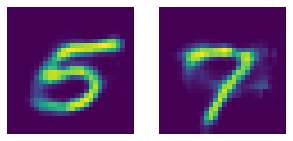

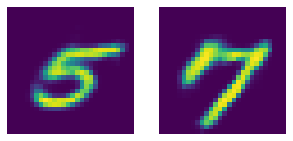

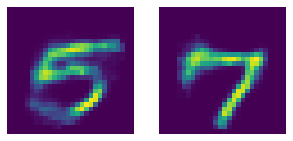

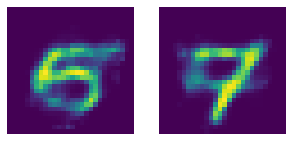

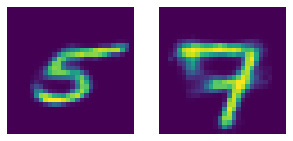

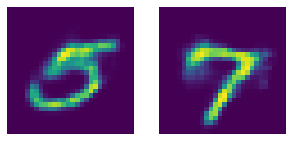

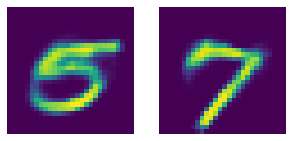

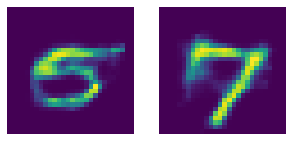

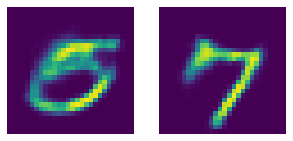

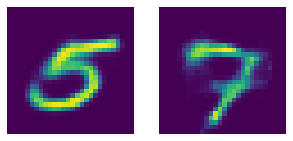

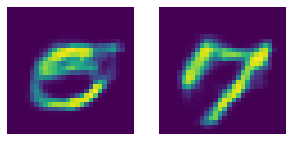

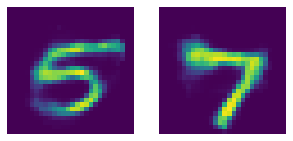

In [93]:
grid_display([new_imgs[i].permute(1, 2, 0).cpu().detach().numpy() for i in range(new_imgs.shape[0])])

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

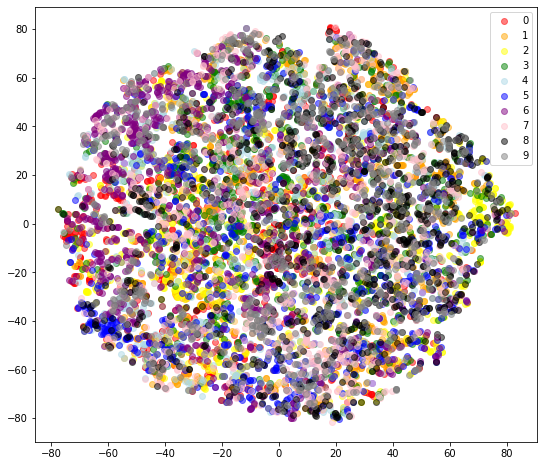

In [88]:
test_latent_vectors = []
test_labels = []

for imgs, labels in test_loader:
    imgs = imgs.view(-1,28*28*1).to(device)
    labels = labels.to(device)
    mu, logsigma = autoencoder.encode(imgs, labels)
    latent_vectors = autoencoder.gaussian_sampler(mu, logsigma)
    latent_vectors = latent_vectors.cpu().detach().numpy()
    test_latent_vectors.append(latent_vectors)
    test_labels.append(labels.cpu().detach().numpy())

X = test_latent_vectors[0]
y = test_labels[0]

for i in range(1, len(test_latent_vectors)):
    X = np.concatenate((X, test_latent_vectors[i]))
    y = np.concatenate((y, test_labels[i]))

X_embedded = TSNE(n_components=2).fit_transform(X)

fig, ax = plt.subplots(figsize=(9, 8))

colors = ['red', 'orange', 'yellow', 'green', 'lightblue', 'blue', 'purple', 'pink', 'black', 'gray']
# colors = _get_n_hex_color(n=10)
for num in list(np.arange(0,10)):
    x_ax = X_embedded[y == num][:,0]
    y_ax = X_embedded[y == num][:,1]
    ax.scatter(x_ax, y_ax, c=colors[num], label=str(num), alpha=0.5)
ax.legend()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# Не успел =(

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>